In [1]:
import pickle
from pathlib import Path
import numpy as np
import statistics
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
import math
from qiskit.quantum_info import *

In [2]:
import numpy as np
import numpy.ma as ma
from ANALYSIS_SPECIFIC_CONFIG import is_valid_pickle_file,spread_per_sample_vectorized,spread_pooling_vectorized, load_and_clean_pickle, extract_Nr, extract_trotter_step

def process_data_dqfim(df, threshold, by_test, Nc, N_R, trot, print_bool=False):
    """
    Create a list of dictionaries, each representing one (fixed_params_key, test_key) row.
    Returns a list of row-dicts for direct DataFrame construction.
    """
    rows = []
    for fixed_params_key, test_dict in df.items():
        for test_key, results in test_dict.items():
            qfim_eigvals = results.get('qfim_eigvals', None)
            qfim_mat = results.get('qfim',None)
            # print(f"qfim_mat.shape: {qfim_mat.shape}")
            entropies      = results.get('entropies', None)
            input_states = results.get('L',None)
            n_reserv = results.get('n_reserv',None)
            # assert n_reserv == N_R, f'{N_R}. Actual: {n_reserv}'
            T = results.get('time_steps',None)
            # assert T == trot, f'{trot}. Actual: {T}'
            row = {
                "N_ctrl": Nc,
                "N_reserv": n_reserv,
                "Trotter_Step": T,
                "fixed_params_key": fixed_params_key,
                "test_key": test_key,
                "qfim_eigvals": qfim_eigvals,
                "qfim_mat":qfim_mat,
                "entropies": entropies,
                "input_states":input_states,
                "num_inputs":len(input_states)
                # Add any other fields you might need later
            }
            rows.append(row)
    return rows
def build_df_expanded_DQFIM(base_path, sample_range, model_type, N_ctrls, K_str,datasize, threshold, by_test):
    """
   
    """
    from pathlib import Path
    import os
    import pandas as pd

    all_expanded_rows = []
    processed_files = []
    
    # Iterate over each N_ctrl value
    for N_ctrl in N_ctrls:
        model_path = Path(base_path) / "QFIM_global_results" / f"{model_type}_model_DQFIM" / f"Nc_{N_ctrl}" / f"sample_{sample_range}/{K_str}xK"
        if not model_path.exists():
            print(f"[WARN] Model path {model_path} does not exist for N_ctrl={N_ctrl}.")
            continue
        
        # Iterate over each Nr directory
        for Nr in sorted(os.listdir(model_path)):
            Nr_path = model_path / Nr
            if not Nr_path.is_dir():
                continue
            
            # Iterate over each trotter step directory
            print(sorted(os.listdir(Nr_path)))
            for trotter_step_dir in sorted(os.listdir(Nr_path)):
                trotter_step_path = Nr_path / trotter_step_dir
                if not trotter_step_path.is_dir():
                    continue
                
                data_file = trotter_step_path / f"L_{datasize}/data.pickle"
                if not data_file.exists():
                    continue
                processed_files.append(data_file)
                # Validate the pickle file without using cached results
                if not is_valid_pickle_file(data_file):
                    continue
                
                # Load the raw pickle data
                raw_data = load_and_clean_pickle(data_file)
                # Extract trotter step and reservoir count from the directory structure
                try:
                    trotter_step_num = extract_trotter_step(data_file)
                    reservoir_count = extract_Nr(data_file)
                except Exception as e:
                    print(f"[ERROR] Could not extract parameters from {data_file}: {e}")
                    continue

                # Process raw data using your expanded function (do not use cached expanded rows)
                expanded_rows = process_data_dqfim(raw_data, threshold, by_test, N_ctrl, reservoir_count, trotter_step_num)
                all_expanded_rows.extend(expanded_rows)

    return pd.DataFrame(all_expanded_rows),processed_files
import numpy as np
import numpy.ma as ma
#############################################
# Revised compute_single_draw_stats function #
#############################################
def compute_single_draw_stats(
    eigvals,
    full_qfim_mat,
    threshold=1e-10,
    spread_methods=("variance", "mad"),
    ddof=1,
    scale="normal",
    gamma=1.0,
    n=1,
    V_theta=1.0,
    n_ctrl=None,
    n_reserv=None,
    trotter_step=None,
):
    """
    Compute QFIM (or DQFIM) statistics for a SINGLE set of eigenvalues (one draw),
    and also compute an effective dimension from the provided full QFIM matrix.
    
    Returned dictionary includes:
      - "draw_rank"
      - "var_all_eigenvalues"
      - "var_nonzero_eigenvalues"
      - "trace_eigenvalues"
      - "var_all_normalized_by_param_count"
      - "trace_normalized_by_rank"
      - "var_nonzero_log"
      - "trace_normalized_by_param_count"
      - "ipr_deff_raw"        (raw IPR measure)
      - "ipr_deff_norm"       (IPR computed on trace-normalized eigenvalues)
      - "abbas_deff_raw"      (sum(log(1 + alpha*λ)) on raw eigenvalues)
      - "abbas_deff_norm"     (sum(log(1 + alpha*λ)) on trace-normalized eigenvalues)
      - "effective_dimension" (computed from the trace-normalized full QFIM)
      - "spread_metric_{method}" for each method in spread_methods.
    
    Parameters
    ----------
    eigvals : array-like
        Eigenvalues for this single QFIM (or DQFIM) draw.
    full_qfim_mat : array-like (2D)
        The full QFIM matrix for this draw.
    threshold : float
        Zero out eigenvalues below this threshold.
    spread_methods : tuple of str
        Methods for "spread-of-log" metrics.
    ddof : int
        Degrees of freedom for variance computations.
    scale : str
        Scale indicator for spread metrics.
    gamma : float
        Scaling parameter in the Abbas formula (typically in (0,1]).
    n : int
        Number of data samples used in the Abbas formula.
    V_theta : float
        Volume factor (typically 1.0).
    n_ctrl, n_reserv, trotter_step : optional
        Additional metadata.
    
    Returns
    -------
    stats_dict : dict
        Dictionary of computed statistics.
    """
    # Ensure eigvals is a 1D NumPy array.
    arr = np.array(eigvals, dtype=float)
    if arr.ndim != 1:
        arr = arr.flatten()
    # Zero out small eigenvalues.
    arr = np.where(arr < threshold, 0.0, arr)
    
    # --- 1) Basic stats ---
    draw_rank = np.count_nonzero(arr)
    var_all_eigenvalues = np.var(arr, ddof=ddof)
    # Variance on nonzero values using Boolean indexing.
    nonzero = arr[arr > threshold]
    var_nonzero_eigenvalues = np.var(nonzero, ddof=ddof) if nonzero.size > 1 else 0.0
    var_nonzero_log = np.log(var_nonzero_eigenvalues) if var_nonzero_eigenvalues > 0 else -np.inf
    trace_eigenvalues = np.sum(arr)
    
    var_normalized_by_param_count = var_all_eigenvalues / len(arr)
    var_nonzero_normalized_by_rank = var_nonzero_eigenvalues / draw_rank
    var_normalized_by_rank = var_all_eigenvalues / draw_rank
    trace_normalized_by_rank = (trace_eigenvalues / draw_rank) if draw_rank > 0 else 0.0
    trace_normalized_by_param_count = trace_eigenvalues / len(arr)
    
    # --- 2) IPR-based dimensions ---
    # Raw IPR: (trace^2) / (sum of squares)
    sum_of_squares = np.sum(arr**2)
    ipr_deff_raw = (trace_eigenvalues**2) / sum_of_squares if sum_of_squares > 0 else 0.0
    
    # Normalized IPR: using normalized eigenvalues (p = λ/trace)
    if trace_eigenvalues > 0:
        arr_norm = arr / trace_eigenvalues
        sum_norm_sq = np.sum(arr_norm**2)
        ipr_deff_norm = 1.0 / sum_norm_sq if sum_norm_sq > 0 else 0.0
    else:
        arr_norm = None
        ipr_deff_norm = 0.0
    
    # --- 3) Abbas-based dimensions ---
    # Compute alpha = (gamma * n) / (2*log(n)) if n>1, else use limit.
    if n > 1 and math.log(n) != 0.0:
        alpha = (gamma * n) / (2.0 * math.log(n))
    else:
        alpha = 0.0
    # Raw Abbas: computed on original eigenvalues.
    abbas_deff_raw = np.sum(np.log(np.maximum(1.0 + alpha * arr, 1e-15)))
    # Normalized Abbas: computed on trace-normalized eigenvalues.
    if arr_norm is not None:
        abbas_deff_norm = np.sum(np.log(np.maximum(1.0 + alpha * arr_norm, 1e-15)))
    else:
        abbas_deff_norm = 0.0
    
    # --- 4) Effective dimension from the full QFIM ---
    # Normalize the full QFIM by its trace BEFORE diagonalizing.
    F = np.array(full_qfim_mat, dtype=float)
    trF = np.trace(F)
    if trF > 0:
        F_hat = F / trF
        eigs_F = np.linalg.eigvalsh(F_hat)  # Eigenvalues of the normalized full QFIM.
        eps = 1e-12
        # Here, effective dimension is computed from the normalized spectrum p_i.
        # If n > 1, use the standard formula; if n == 1, use the limit:
        if n > 1 and math.log(n) != 0.0:
            z = 0.5 * np.sum(np.log(1.0 + n * eigs_F + eps))
            effective_dimension = (2.0 / np.log(n)) * z
        else:
            # For n == 1, define effective dimension as the sum_i p_i/(1+p_i)
            effective_dimension = np.sum(eigs_F / (1.0 + eigs_F))
    else:
        effective_dimension = 0.0
    
    # --- 5) Spread-of-log metrics ---
    # Reshape arr into a 1-row 2D array for external functions.
    arr_2d = arr.reshape(1, -1)
    spread_metrics = {}
    for method in spread_methods:
        per_draw = spread_per_sample_vectorized(arr_2d, method=method, threshold=threshold, ddof=ddof, scale=scale)
        spread_metrics[f"spread_metric_{method}"] = per_draw[0] if per_draw.size > 0 else 0.0
    
    # --- 6) Build final dictionary ---
    stats_dict = {
        # Basic stats
        "draw_rank": draw_rank,
        "var_all_eigenvalues": var_all_eigenvalues,
        "var_nonzero_eigenvalues": var_nonzero_eigenvalues,
        "trace_eigenvalues": trace_eigenvalues,
        "var_all_normalized_by_param_count": var_normalized_by_param_count,
        "var_all_normalized_by_rank": var_normalized_by_rank,
        "var_nonzero_normalized_by_rank":var_nonzero_normalized_by_rank,
        "trace_normalized_by_rank": trace_normalized_by_rank,
        "trace_normalized_by_param_count": trace_normalized_by_param_count,
        "var_nonzero_log": var_nonzero_log,
        
        # IPR-based dimensions
        "ipr_deff_raw": ipr_deff_raw,
        "ipr_deff_norm": ipr_deff_norm,
        
        # Abbas-based dimensions
        "abbas_deff_raw": abbas_deff_raw,
        "abbas_deff_norm": abbas_deff_norm,
        
        # Effective dimension computed from the full QFIM (trace-normalized)
        "d_eff": effective_dimension,
    }
    stats_dict.update(spread_metrics)
    
    return stats_dict

In [109]:
import os
import pickle
import numpy as np
import pandas as pd
from IPython.display import display  # Ensure this is not overwritten elsewhere


def clean_array(data):
    """Helper function to clean any deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Ensure the array doesn't have deprecated attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    else:
        return data

def get_dqfim_full_from_storage(num_L,N_R,N_C, T,test_key,fixed_param_dict_key="fixed_params0"):

    file_path = (
        f"/Users/sophieblock/QRCcapstone/parameter_analysis_directory/"
        f"QFIM_global_results/gate_model_DQFIM/Nc_{N_C}/sample_pi/1bbxK/"
        f"Nr_{N_R}/trotter_step_{T}/L_{num_L}/data.pickle"
    )
    # print(file_path)
    with open(file_path, 'rb') as f:
        all_tests_data = pickle.load(f)


    results = all_tests_data[fixed_param_dict_key][test_key]
    return results.get('qfim',None)
def read_jax_file(file_path, gate_name,test_key):
    """
   
    """
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
    df = clean_array(df)
    # print(df.keys())
    # print(df.get('controls', None), df.get('controls', None)[0])
    try:
        costs = np.asarray([float(i) for i in df['costs'][0]], dtype=np.float64)
    except Exception as e:
        print(f"Error reading costs from {file_path}: {e}")
        costs = None
        
    try:
        grads_per_epoch = [np.asarray(i, dtype=np.float64) for i in df['grads_per_epoch'][0]]
    except Exception as e:
        print(f"Error reading grads_per_epoch from {file_path}: {e}")
        grads_per_epoch = None
        
    try:
        fidelity = float(df['avg_fidelity'][0])
    except Exception as e:
        print(f"Error reading avg_fidelity from {file_path}: {e}")
        fidelity = None
        
    try:
        num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
    except Exception as e:
        print(f"Error computing num_params from {file_path}: {e}")
        num_params = None
        
    try:
        test_results = np.asarray(df['testing_results'][0], dtype=np.float64)
    except Exception as e:
        print(f"Error reading testing_results from {file_path}: {e}")
        test_results = None
        
    # Read QFIM Results (GHZ initial state)
    qfim_stats_dict_GHZ = df.get('QFIM Results', [None])[0]
    if qfim_stats_dict_GHZ is None:
        print(f"Warning: 'QFIM Results' not found in {file_path}")
        qfim_eigvals_GHZ = qfim_full_GHZ = entropy_GHZ = None
    else:
        qfim_eigvals_GHZ = qfim_stats_dict_GHZ.get('qfim_eigvals', None)
        if qfim_eigvals_GHZ is None:
            print(f"Warning: 'qfim_eigvals' not found in QFIM Results in {file_path}")
        qfim_full_GHZ = qfim_stats_dict_GHZ.get('qfim', None)
        entropy_GHZ = qfim_stats_dict_GHZ.get('entropy', None)
    
    # Read QFIM Basis State stats
    qfim_stats_dict_basis = df.get('QFIM_basis_state', [None])[0]
    if qfim_stats_dict_basis is None:
        print(f"Warning: 'QFIM_basis_state' not found in {file_path}")
        qfim_eigvals = qfim_full = entropy = None
    else:
        qfim_eigvals = qfim_stats_dict_basis.get('qfim_eigvals', None)
        if qfim_eigvals is None:
            print(f"Warning: 'qfim_eigvals' not found in QFIM_basis_state in {file_path}")
        qfim_full = qfim_stats_dict_basis.get('qfim', None)
        entropy = qfim_stats_dict_basis.get('entropy', None)
    
    # Read DQFIM stats
    dqfim_stats_dict = df.get('DQFIM_stats', [None])[0]
    if dqfim_stats_dict is None:
        print(f"Warning: 'DQFIM_stats' not found in {file_path}")
        dqfim_eigvals = dqfim_full = dqfim_entropies = L_val = None
    else:
        dqfim_eigvals = dqfim_stats_dict.get('dqfim_eigvals', None)
        if dqfim_eigvals is None:
            print(f"Warning: 'qfim_eigvals' not found in DQFIM_stats in {file_path}")
        dqfim_full = dqfim_stats_dict.get('dqfim', None)
        L = dqfim_stats_dict.get('L', None)
        if dqfim_full is None:
            # extract from raw file
            dqfim_full = get_dqfim_full_from_storage(num_L=len(L),N_R=df.get('reservoirs', None)[0],N_C= df.get('controls', None)[0], T = df.get('trotter_step', None)[0], test_key=test_key)
        dqfim_entropies = dqfim_stats_dict.get('entropies', None)
    


    # Read target DQFIM stats
    target_dqfim_stats_dict = df.get("target DQFIM stats", [None])[0]
    if target_dqfim_stats_dict is None:
        print(f"Warning: 'target DQFIM stats' not found in {file_path}")
        target_dqfim_eigvals = target_dqfim_full = target_dqfim_entropies = None
    else:
        target_dqfim_eigvals = target_dqfim_stats_dict.get('dqfim_eigvals', None)
        target_dqfim_full = target_dqfim_stats_dict.get('DQFIM', None)
        target_dqfim_entropies = target_dqfim_stats_dict.get('entropies', None)
    
    result = {
        "costs": costs,
        "fidelity": fidelity,
        "num_params": num_params,
        "test_results": test_results,
        "qfim_eigvals_GHZ": qfim_eigvals_GHZ,
        "qfim_full_GHZ": qfim_full_GHZ,
        "entropy_GHZ": entropy_GHZ,
        "qfim_eigvals": qfim_eigvals,
        "qfim_full": qfim_full,
        "entropy": entropy,
        "dqfim_eigvals": dqfim_eigvals,
        "dqfim_full": dqfim_full,
        "dqfim_entropies": dqfim_entropies,
        "L": L,
        "num_sampled_states": len(L) if L is not None else 0,
        "target_dqfim_eigvals": target_dqfim_eigvals,
        "target_dqfim_full": target_dqfim_full,
        "target_dqfim_entropies": target_dqfim_entropies,
        "num_train": len(L) if len(L) == len(target_dqfim_entropies) else len(target_dqfim_entropies),
        "N_ctrl": df.get('controls', None)[0],
        "Trotter_Step": df.get('trotter_step', None)[0],
        "N_R": df.get('reservoirs', None)[0],
        "gate": gate_name
    }
    return result
def build_df_results(fixed_param_folder, base_folder,N_C = 2):
    """
    Build a DataFrame by reading pickle files stored in the following hierarchy:
    
    base_folder/
        trainsize_{train_size}/
            sample_pi/
                {fixed_param_folder}/
                    {test_key}/
                        {gate_folder}/
                            data_run_0.pickle

    For each pickle file, this function calls read_jax_file to extract relevant fields,
    and adds additional columns for 'test_key' and 'gate_folder'.

    Parameters
    ----------
    fixed_param_folder : str
        The folder name for fixed parameters (e.g. 'fixed_params0').
    base_folder : str
        The base directory for the experiment results. For example:
        "/Users/sophieblock/QRCCapstone/parameter_analysis_directory/param_initialization_final/digital_results/Nc_2/reservoirs_1/trotter_8/trainsize_10/sample_pi"

    Returns
    -------
    pd.DataFrame
        A DataFrame where each row corresponds to one pickle file's extracted data,
        augmented with the test key and gate folder.
    """
    rows = []
    full_path = os.path.join(base_folder, fixed_param_folder)
    # print(f"Scanning results in: {full_path}")
    
    # Loop over test key folders.
    for test_key in os.listdir(full_path):
        test_key_path = os.path.join(full_path, test_key)
        if not os.path.isdir(test_key_path):
            print(f"Skipping non-directory: {test_key_path}")
            continue
        
        # Loop over gate folders inside each test key folder.
        for gate_folder in os.listdir(test_key_path):
            # Enforce expected naming.
            if not gate_folder.startswith(f"U{N_C}_"):
                # print(f"Skipping gate folder {gate_folder} as it does not match expected pattern.")
                continue
            gate_folder_path = os.path.join(test_key_path, gate_folder)
            if not os.path.isdir(gate_folder_path):
                print(f"Skipping non-directory: {gate_folder_path}")
                continue
            pickle_file = os.path.join(gate_folder_path, "data_run_0.pickle")
            # print(f"Looking for pickle file: {pickle_file}")
            if os.path.isfile(pickle_file):
                try:
                    # Use read_jax_file to extract the data.
                    data = read_jax_file(pickle_file, gate_folder,test_key)
                    # Add metadata.
                    data["test_key"] = test_key
                    data["gate_folder"] = gate_folder
                    data["file_path"] = pickle_file
                    rows.append(data)
                    # print(f"Loaded data from {pickle_file}")
                except Exception as ex:
                    print(f"Error processing {pickle_file}: {ex}")
            else:
                print(f"Pickle file does not exist: {pickle_file}")
    
    df_results = pd.DataFrame(rows)
    return df_results


trotter_Step = 14
fixed_param_folder = "fixed_params0"
num_epochs = 1500
train_size = 20
base_folder = f"/Users/sophieblock/QRCCapstone/parameter_analysis_directory/param_initialization_final/digital_results_res2/Nc_2//epochs_{num_epochs}/reservoirs_1/trotter_{trotter_Step}/trainsize_{train_size}/sample_pi"
df_results = build_df_results(fixed_param_folder, base_folder)

print("df_results shape:", df_results.shape)

#  /Users/sophieblock/QRCCapstone/parameter_analysis_directory/param_initialization_final/digital_results/Nc_2/epochs_1000/reservoirs_1/trotter_12/trainsize_20/sample_positive_pi/fixed_params0/test0
# IMPORTANT: If you get an error saying "TypeError: 'list' object is not callable" when calling display(df_results.head()),
# ensure that you haven't overwritten the built-in 'display' function (e.g., by assigning a list to display).
# display(df_results.head())

df_results shape: (120, 26)


In [26]:
df_results['test_key'].unique()

array(['test18', 'test104', 'test7', 'test175', 'test129', 'test79',
       'test197', 'test122'], dtype=object)

In [33]:
df_results.keys()

Index(['costs', 'fidelity', 'num_params', 'test_results', 'qfim_eigvals',
       'qfim_full', 'entropy', 'N_ctrl', 'Trotter_Step', 'N_R', 'gate',
       'test_key', 'gate_folder', 'file_path'],
      dtype='object')

In [111]:
import numpy as np
import pandas as pd
def aggregate_results(df):
    """
    Aggregate the DataFrame by test_key and gate.
    For each test_key/gate combination, aggregate key columns.
    """
    aggregated = df.groupby(["test_key", "gate"]).agg(
        fidelities_list=("fidelity", list),
        avg_fidelity=("fidelity", "mean"),
        error=("fidelity", lambda x: np.mean(np.log(1 - x))),
        qfim_eigvals_GHZ=("qfim_eigvals_GHZ", "first"),
        qfim_full_GHZ=("qfim_full_GHZ", "first"),
        entropy_GHZ=("entropy_GHZ", "first"),
        qfim_eigvals=("qfim_eigvals", "first"),
        qfim_full=("qfim_full", "first"),
        entropy=("entropy", "first"),
        dqfim_eigvals=("dqfim_eigvals", "first"),
        dqfim_full=("dqfim_full", "first"),
        dqfim_entropies=("dqfim_entropies", "first"),
        target_dqfim_eigvals=("target_dqfim_eigvals", "first"),
        target_dqfim_full=("target_dqfim_full", "first"),
        target_dqfim_entropies=("target_dqfim_entropies", "first"),
        N_ctrl=("N_ctrl", "first"),
        N_R=("N_R", "first"),
        Trotter_Step=("Trotter_Step", "first"),
        L=("L", "first"),
        num_sampled_states=("num_sampled_states", "first"),
        num_train = ("num_train","first")
    ).reset_index()
    
    return aggregated


def update_with_all_qfim_metrics(df, threshold=1e-12, spread_methods=("variance", "mad"),
                                 ddof=1, scale="normal", gamma=0.1, n=1, V_theta=1.0):
    """
    For each row (one test_key/gate combination), compute derived metrics for all four QFIM variants:
      - GHZ QFIM (from "qfim_eigvals_GHZ" and "qfim_full_GHZ")
      - Basis QFIM (from "qfim_eigvals" and "qfim_full")
      - DQFIM (from "dqfim_eigvals"; note: if you don’t store a full DQFIM matrix, you may need to pass a dummy matrix)
      - Target DQFIM (from "target_dqfim_eigvals" and "target_dqfim_full")
    
    Returns a new DataFrame with the computed stats added with suffixes.
    """
    new_rows = []
    for _, row in df.iterrows():
        # GHZ QFIM metrics:
        ghz_stats = compute_single_draw_stats(
            row["qfim_eigvals_GHZ"],
            row["qfim_full_GHZ"],
            threshold=threshold,
            spread_methods=spread_methods,
            ddof=ddof,
            scale=scale,
            gamma=gamma,
            n=n,
            V_theta=V_theta,
            n_ctrl=row["N_ctrl"],
            n_reserv=row["N_R"],
            trotter_step=row["Trotter_Step"]
        )
        # Basis QFIM metrics:
        basis_stats = compute_single_draw_stats(
            row["qfim_eigvals"],
            row["qfim_full"],
            threshold=threshold,
            spread_methods=spread_methods,
            ddof=ddof,
            scale=scale,
            gamma=gamma,
            n=n,
            V_theta=V_theta,
            n_ctrl=row["N_ctrl"],
            n_reserv=row["N_R"],
            trotter_step=row["Trotter_Step"]
        )
        # DQFIM metrics:
     
        assert isinstance(row['num_sampled_states'],int)
        dqfim_stats = compute_single_draw_stats(
            row["dqfim_eigvals"],
            row["dqfim_full"],
            threshold=threshold,
            spread_methods=spread_methods,
            ddof=ddof,
            scale=scale,
            gamma=gamma,
            n=row['num_sampled_states'],
            V_theta=V_theta,
            n_ctrl=row["N_ctrl"],
            n_reserv=row["N_R"],
            trotter_step=row["Trotter_Step"]
        )
       
        # Target DQFIM metrics:
        target_stats = compute_single_draw_stats(
            row["target_dqfim_eigvals"],
            row["target_dqfim_full"],
            threshold=threshold,
            spread_methods=spread_methods,
            ddof=ddof,
            scale=scale,
            gamma=gamma,
            n=row['num_train'],
            V_theta=V_theta,
            n_ctrl=row["N_ctrl"],
            n_reserv=row["N_R"],
            trotter_step=row["Trotter_Step"]
        )
        
        updated_row = row.to_dict()
        # Add the computed stats with suffixes to distinguish them.
        updated_row.update({f"GHZ_{k}": v for k, v in ghz_stats.items()})
        updated_row.update({f"basis_{k}": v for k, v in basis_stats.items()})
        updated_row.update({f"dqfim_{k}": v for k, v in dqfim_stats.items()})
        updated_row.update({f"target_{k}": v for k, v in target_stats.items()})
        new_rows.append(updated_row)
    return pd.DataFrame(new_rows)

df_agg = aggregate_results(df_results)
print("Aggregated DataFrame shape:", df_agg.shape)
display(df_agg.keys())


df_final = update_with_all_qfim_metrics(df_agg)
df_final.shape


Aggregated DataFrame shape: (120, 23)


Index(['test_key', 'gate', 'fidelities_list', 'avg_fidelity', 'error',
       'qfim_eigvals_GHZ', 'qfim_full_GHZ', 'entropy_GHZ', 'qfim_eigvals',
       'qfim_full', 'entropy', 'dqfim_eigvals', 'dqfim_full',
       'dqfim_entropies', 'target_dqfim_eigvals', 'target_dqfim_full',
       'target_dqfim_entropies', 'N_ctrl', 'N_R', 'Trotter_Step', 'L',
       'num_sampled_states', 'num_train'],
      dtype='object')

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_82297/2990458844.py:210: ComplexWarning:

Casting complex values to real discards the imaginary part



(120, 91)

In [116]:
# Filter for test_key 'test104' and gates 'U2_0' or 'U2_1'
subset_df = df_agg[
    (df_agg["test_key"] == "test104") & 
    (df_agg["gate"].isin(["U2_0", "U2_1"]))
][["gate", "test_key", "target_dqfim_eigvals", "qfim_eigvals_GHZ"]]

display(subset_df)

,gate,test_key,target_dqfim_eigvals,qfim_eigvals_GHZ
0,U2_0,test104,"[-1.2358426e-16, -7.742247e-17, -4.27567e-17, ...","[-2.3746058e-16, -1.9421301e-16, -1.174653e-16..."
1,U2_1,test104,"[-8.9524295e-17, -5.0148797e-17, -3.8625023e-1...","[-2.3746058e-16, -1.9421301e-16, -1.174653e-16..."


In [117]:
# Filter for test_key 'test104' and gates 'U2_0' or 'U2_1'
subset_df = df_final[
    (df_final["test_key"] == "test104") & 
    (df_final["gate"].isin(["U2_0", "U2_1"]))
][["gate", "test_key", "target_dqfim_eigvals",'target_trace_normalized_by_rank', "qfim_eigvals_GHZ",'GHZ_trace_normalized_by_rank']]

display(subset_df)

,gate,test_key,target_dqfim_eigvals,target_trace_normalized_by_rank,qfim_eigvals_GHZ,GHZ_trace_normalized_by_rank
0,U2_0,test104,"[-1.2358426e-16, -7.742247e-17, -4.27567e-17, ...",1.167499,"[-2.3746058e-16, -1.9421301e-16, -1.174653e-16...",5.227454
1,U2_1,test104,"[-8.9524295e-17, -5.0148797e-17, -3.8625023e-1...",1.301251,"[-2.3746058e-16, -1.9421301e-16, -1.174653e-16...",5.227454


In [ ]:
df_final

In [113]:
df_final.columns

Index(['test_key', 'gate', 'fidelities_list', 'avg_fidelity', 'error',
       'qfim_eigvals_GHZ', 'qfim_full_GHZ', 'entropy_GHZ', 'qfim_eigvals',
       'qfim_full', 'entropy', 'dqfim_eigvals', 'dqfim_full',
       'dqfim_entropies', 'target_dqfim_eigvals', 'target_dqfim_full',
       'target_dqfim_entropies', 'N_ctrl', 'N_R', 'Trotter_Step', 'L',
       'num_sampled_states', 'num_train', 'GHZ_draw_rank',
       'GHZ_var_all_eigenvalues', 'GHZ_var_nonzero_eigenvalues',
       'GHZ_trace_eigenvalues', 'GHZ_var_all_normalized_by_param_count',
       'GHZ_var_all_normalized_by_rank', 'GHZ_var_nonzero_normalized_by_rank',
       'GHZ_trace_normalized_by_rank', 'GHZ_trace_normalized_by_param_count',
       'GHZ_var_nonzero_log', 'GHZ_ipr_deff_raw', 'GHZ_ipr_deff_norm',
       'GHZ_abbas_deff_raw', 'GHZ_abbas_deff_norm', 'GHZ_d_eff',
       'GHZ_spread_metric_variance', 'GHZ_spread_metric_mad',
       'basis_draw_rank', 'basis_var_all_eigenvalues',
       'basis_var_nonzero_eigenvalues', 'ba

In [114]:
import pingouin as pg

def analyze_correlations(df_merged, x_metric, metrics_of_interest, corr_threshold=0.2, p_threshold=0.05):
    """
    Analyze pairwise correlations between a given x_metric and each metric in metrics_of_interest.
    
    Parameters
    ----------
    df_merged : pd.DataFrame
        The merged DataFrame containing the columns of interest.
    x_metric : str
        The column name for the independent variable (e.g., "avg_fidelity").
    metrics_of_interest : list of str
        List of column names whose correlations with x_metric will be computed.
    corr_threshold : float, optional
        Minimum absolute correlation coefficient to report (default 0.2).
    p_threshold : float, optional
        Maximum p-value threshold to report (default 0.05).
        
    Returns
    -------
    pearson_results : dict
        Dictionary mapping each metric to its Pearson correlation coefficient and p-value.
    spearman_results : dict
        Dictionary mapping each metric to its Spearman correlation coefficient and p-value.
    """
    # Create a new DataFrame with the columns of interest and drop rows with NaN values.
    df_corr = df_merged[[x_metric] + metrics_of_interest].copy()
    df_corr = df_corr.dropna(subset=[x_metric] + metrics_of_interest)
    # print("Columns in df_corr:", df_corr.columns)
    # print("Number of rows after dropna:", len(df_corr))
    
    # Ensure that each metric column contains float values (e.g., convert from JAX arrays if needed)
    for col in metrics_of_interest:
        df_corr[col] = df_corr[col].apply(
            lambda val: float(val.item()) if hasattr(val, "item") else float(val)
        )
    
    # Compute Pearson correlations for each metric.
    pearson_results = {}
    for col in metrics_of_interest:
        res_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="pearson")
        r_val = res_df["r"].iloc[0]
        p_val = res_df["p-val"].iloc[0]
        pearson_results[col] = {"pearson_r": r_val, "p_value": p_val}
    
    # Compute Spearman correlations for each metric.
    spearman_results = {}
    for col in metrics_of_interest:
        sp_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="spearman")
        rho_val = sp_df["r"].iloc[0]
        p_val = sp_df["p-val"].iloc[0]
        spearman_results[col] = {"spearman_rho": rho_val, "p_value": p_val}
    
    # Print out the correlations that meet the filtering thresholds.
    print(f"\nPairwise correlations vs. {x_metric} (Pearson):")
    for metric, vals in pearson_results.items():
        if abs(vals["pearson_r"]) > corr_threshold and vals["p_value"] < p_threshold:
            print(f"{metric}: r={vals['pearson_r']:.3f}, p={vals['p_value']:.3g}")
    
    print(f"\nPairwise correlations vs. {x_metric} (Spearman):")
    for metric, vals in spearman_results.items():
        if abs(vals["spearman_rho"]) > corr_threshold and vals["p_value"] < p_threshold:
            print(f"{metric}: rho={vals['spearman_rho']:.3f}, p={vals['p_value']:.3g}")
    
    return pearson_results, spearman_results


In [119]:
CORR_THRESHOLD = 0.2
P_THRESHOLD = 0.05
x_metric = "avg_fidelity"
metrics_of_interest_ghz = [

  
       'GHZ_var_all_normalized_by_rank', 'GHZ_var_nonzero_normalized_by_rank',
       'GHZ_trace_normalized_by_rank', 
       'GHZ_var_nonzero_log',  'GHZ_ipr_deff_norm',
       'GHZ_abbas_deff_raw', 'GHZ_abbas_deff_norm', 'GHZ_d_eff',
       'GHZ_spread_metric_variance', 'GHZ_spread_metric_mad',
]
# Now you can use these common thresholds in your calls:
pearson_corrs_ghz, spearman_corrs_ghz = analyze_correlations(
    df_final, x_metric, metrics_of_interest_ghz,
    corr_threshold=CORR_THRESHOLD, p_threshold=P_THRESHOLD
)


metrics_of_interest_basis = [


  
       'basis_var_all_normalized_by_rank',
       'basis_var_nonzero_normalized_by_rank',
       'basis_trace_normalized_by_rank',
        'basis_var_nonzero_log',
      'basis_ipr_deff_norm', 'basis_abbas_deff_raw',
       'basis_abbas_deff_norm', 'basis_d_eff', 'basis_spread_metric_variance',
       'basis_spread_metric_mad'
]
pearson_corrs_basis, spearman_corrs_basis = analyze_correlations(
    df_final, x_metric, metrics_of_interest_basis,
    corr_threshold=CORR_THRESHOLD, p_threshold=P_THRESHOLD
)


metrics_of_interest_dqfim = [

     
       'dqfim_var_all_normalized_by_rank',
       'dqfim_var_nonzero_normalized_by_rank',
       'dqfim_trace_normalized_by_rank',
       'dqfim_var_nonzero_log',
     'dqfim_ipr_deff_norm', 'dqfim_abbas_deff_raw',
       'dqfim_abbas_deff_norm', 'dqfim_d_eff', 'dqfim_spread_metric_variance',
       'dqfim_spread_metric_mad'
]
pearson_corrs_dqfim, spearman_corrs_dqfim = analyze_correlations(
    df_final, x_metric, metrics_of_interest_dqfim,
    corr_threshold=CORR_THRESHOLD, p_threshold=P_THRESHOLD
)


metrics_of_interest_targ_dqfim = [
    
       'target_var_all_normalized_by_rank',
       'target_var_nonzero_normalized_by_rank',
       'target_trace_normalized_by_rank',
       'target_var_nonzero_log',
      'target_ipr_deff_norm', 'target_abbas_deff_raw',
       'target_abbas_deff_norm', 'target_d_eff',
       'target_spread_metric_variance', 'target_spread_metric_mad']
pearson_corrs_targ, spearman_corrs_targ = analyze_correlations(
    df_final, x_metric, metrics_of_interest_targ_dqfim,
    corr_threshold=CORR_THRESHOLD, p_threshold=P_THRESHOLD
)
# print(f"\nPairwise correlations vs. {x_metric} (Pearson):")
# for metric, vals in pearson_corrs.items():
    
#     print(f"{metric}: r={vals['pearson_r']:.3f}, p={vals['p_value']:.3g}")


Pairwise correlations vs. avg_fidelity (Pearson):

Pairwise correlations vs. avg_fidelity (Spearman):

Pairwise correlations vs. avg_fidelity (Pearson):

Pairwise correlations vs. avg_fidelity (Spearman):

Pairwise correlations vs. avg_fidelity (Pearson):
dqfim_abbas_deff_norm: r=0.205, p=0.0246

Pairwise correlations vs. avg_fidelity (Spearman):

Pairwise correlations vs. avg_fidelity (Pearson):
target_ipr_deff_norm: r=0.207, p=0.0233
target_abbas_deff_norm: r=0.221, p=0.0153

Pairwise correlations vs. avg_fidelity (Spearman):
target_spread_metric_mad: rho=0.295, p=0.00105


/Users/sophieblock/miniforge3/envs/torch_env/lib/python3.11/site-packages/pingouin/correlation.py:604: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/sophieblock/miniforge3/envs/torch_env/lib/python3.11/site-packages/pingouin/correlation.py:606: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/sophieblock/miniforge3/envs/torch_env/lib/python3.11/site-packages/pingouin/correlation.py:604: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/sophieblock/miniforge3/envs/torch_env/lib/python3.11/site-packages/pingouin/correlation.py:606: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



In [ ]:
selected_metrics = ['basis_var_nonzero_normalized_by_rank', 'basis_trace_normalized_by_rank', 'dqfim_ipr_deff_raw', 'dqfim_abbas_deff_norm','target_spread_metric_mad']

In [120]:
import plotly.express as px
predictor_metrics = [
 
    # 'error',
   'dqfim_abbas_deff_norm','target_ipr_deff_raw','target_abbas_deff_norm','target_spread_metric_mad'

]
metrics_to_visualize = [
    "test_key",
    'avg_fidelity',
    
]
metrics_to_visualize.extend(predictor_metrics)
df_viz = df_final[metrics_to_visualize].dropna()

fig = px.scatter_matrix(
    df_viz,
    dimensions=predictor_metrics,
    color="avg_fidelity",        # Use fidelity as the color dimension
    hover_data=["test_key"],      # Show test_key on hover
    title="Scatter Matrix of Predictors with Fidelity as Color"
)
fig.update_layout(width=1000, height=1000)
fig.show()




In [13]:
df_final.columns

Index(['test_key', 'gate', 'fidelities_list', 'avg_fidelity', 'error',
       'qfim_eigvals_GHZ', 'qfim_full_GHZ', 'entropy_GHZ', 'qfim_eigvals',
       'qfim_full', 'entropy', 'dqfim_eigvals', 'dqfim_full',
       'dqfim_entropies', 'target_dqfim_eigvals', 'target_dqfim_full',
       'target_dqfim_entropies', 'N_ctrl', 'N_R', 'Trotter_Step', 'L',
       'num_sampled_states', 'GHZ_draw_rank', 'GHZ_var_all_eigenvalues',
       'GHZ_var_nonzero_eigenvalues', 'GHZ_trace_eigenvalues',
       'GHZ_var_all_normalized_by_param_count',
       'GHZ_var_all_normalized_by_rank', 'GHZ_var_nonzero_normalized_by_rank',
       'GHZ_trace_normalized_by_rank', 'GHZ_trace_normalized_by_param_count',
       'GHZ_var_nonzero_log', 'GHZ_ipr_deff_raw', 'GHZ_ipr_deff_norm',
       'GHZ_abbas_deff_raw', 'GHZ_abbas_deff_norm', 'GHZ_d_eff',
       'GHZ_spread_metric_variance', 'GHZ_spread_metric_mad',
       'basis_draw_rank', 'basis_var_all_eigenvalues',
       'basis_var_nonzero_eigenvalues', 'basis_trace_eig

In [17]:
# Filter for test_key 'test104' and gates 'U2_0' or 'U2_1'
subset_df = df_final[
    (df_final["test_key"] == "test104") & 
    (df_final["gate"].isin(["U2_0", "U2_1"]))
][["gate", "test_key", "target_dqfim_eigvals",'target_trace_normalized_by_rank', "qfim_eigvals_GHZ",'GHZ_trace_normalized_by_rank']]

display(subset_df)

,gate,test_key,target_dqfim_eigvals,target_trace_normalized_by_rank,qfim_eigvals_GHZ,GHZ_trace_normalized_by_rank
0,U2_0,test104,"[-1.2358426e-16, -7.742247e-17, -4.27567e-17, ...",1.167499,"[-2.3746058e-16, -1.9421301e-16, -1.174653e-16...",5.227454
1,U2_1,test104,"[-8.9524295e-17, -5.0148797e-17, -3.8625023e-1...",1.301251,"[-2.3746058e-16, -1.9421301e-16, -1.174653e-16...",5.227454


In [121]:
numeric_cols = []
for col in df_final.columns:
    if pd.api.types.is_numeric_dtype(df_final[col]):
        numeric_cols.append(col)

# 2) Group by test_key and compute the mean for these numeric columns.
#    numeric_only=True ensures that Pandas only attempts to average numeric data.
df_agg_by_test_key = (
    df_final
    .groupby("test_key")[numeric_cols]
    .mean(numeric_only=True)  # or just .mean() if you're on older Pandas versions
    .reset_index()
)

print("Aggregated DataFrame (one row per test_key):")
print(df_agg_by_test_key.columns)
# df_agg_by_test_key.head()
subset_df_new = df_agg_by_test_key[df_agg_by_test_key["test_key"] == "test104"][["test_key",'target_trace_normalized_by_rank', 'GHZ_trace_normalized_by_rank']]

display(subset_df_new)

Aggregated DataFrame (one row per test_key):
Index(['test_key', 'avg_fidelity', 'error', 'N_ctrl', 'N_R', 'Trotter_Step',
       'num_sampled_states', 'num_train', 'GHZ_draw_rank',
       'GHZ_var_all_eigenvalues', 'GHZ_var_nonzero_eigenvalues',
       'GHZ_trace_eigenvalues', 'GHZ_var_all_normalized_by_param_count',
       'GHZ_var_all_normalized_by_rank', 'GHZ_var_nonzero_normalized_by_rank',
       'GHZ_trace_normalized_by_rank', 'GHZ_trace_normalized_by_param_count',
       'GHZ_var_nonzero_log', 'GHZ_ipr_deff_raw', 'GHZ_ipr_deff_norm',
       'GHZ_abbas_deff_raw', 'GHZ_abbas_deff_norm', 'GHZ_d_eff',
       'GHZ_spread_metric_variance', 'GHZ_spread_metric_mad',
       'basis_draw_rank', 'basis_var_all_eigenvalues',
       'basis_var_nonzero_eigenvalues', 'basis_trace_eigenvalues',
       'basis_var_all_normalized_by_param_count',
       'basis_var_all_normalized_by_rank',
       'basis_var_nonzero_normalized_by_rank',
       'basis_trace_normalized_by_rank',
       'basis_trace_nor

,test_key,target_trace_normalized_by_rank,GHZ_trace_normalized_by_rank
0,test104,1.127361,5.227454


In [21]:
df_agg_by_test_key.head()

,test_key,avg_fidelity,error,N_ctrl,N_R,Trotter_Step,num_sampled_states,GHZ_draw_rank,GHZ_var_all_eigenvalues,GHZ_var_nonzero_eigenvalues,...,target_trace_normalized_by_rank,target_trace_normalized_by_param_count,target_var_nonzero_log,target_ipr_deff_raw,target_ipr_deff_norm,target_abbas_deff_raw,target_abbas_deff_norm,target_d_eff,target_spread_metric_variance,target_spread_metric_mad
0,test104,0.995506,-6.319582,2.0,1.0,14.0,100.0,15.0,135.964760,276.241755,...,1.127361,0.545497,2.526072,1.437149,1.437149,4.947428,0.821075,2.467806,6.666071,2.533476
1,test122,0.996135,-6.010960,2.0,1.0,14.0,100.0,15.0,147.737848,300.070239,...,0.637075,0.308262,1.245983,1.622868,1.622868,4.008202,0.845148,2.974297,4.707227,2.234916
2,test129,0.997454,-6.377038,2.0,1.0,14.0,100.0,15.0,3.334791,6.182687,...,0.337989,0.163543,-0.560077,2.645532,2.645532,3.275069,0.920214,3.585424,5.566216,2.625543
3,test175,0.996774,-6.302271,2.0,1.0,14.0,100.0,15.0,3.620316,6.239774,...,0.487924,0.236092,0.272318,2.423594,2.423594,4.042034,0.907585,3.507252,4.455317,2.277409
4,test18,0.998241,-6.645907,2.0,1.0,14.0,100.0,15.0,3.815765,6.809314,...,0.278918,0.134961,-1.651836,4.530555,4.530555,3.236409,0.976508,4.121240,5.419548,2.822660


In [122]:
CORR_THRESHOLD = 0.2
P_THRESHOLD = 0.02
x_metric = "error"
metrics_of_interest_ghz = [

  
       'GHZ_var_all_normalized_by_rank', 'GHZ_var_nonzero_normalized_by_rank',
       'GHZ_trace_normalized_by_rank', 
       'GHZ_var_nonzero_log',  'GHZ_ipr_deff_norm',
       'GHZ_abbas_deff_raw', 'GHZ_abbas_deff_norm', 'GHZ_d_eff',
       'GHZ_spread_metric_variance', 'GHZ_spread_metric_mad',
]
# Now you can use these common thresholds in your calls:
pearson_corrs_ghz, spearman_corrs_ghz = analyze_correlations(
    df_agg_by_test_key, x_metric, metrics_of_interest_ghz,
    corr_threshold=CORR_THRESHOLD, p_threshold=P_THRESHOLD
)


metrics_of_interest_basis = [


  
       'basis_var_all_normalized_by_rank',
       'basis_var_nonzero_normalized_by_rank',
       'basis_trace_normalized_by_rank',
        'basis_var_nonzero_log',
      'basis_ipr_deff_norm', 'basis_abbas_deff_raw',
       'basis_abbas_deff_norm', 'basis_d_eff', 'basis_spread_metric_variance',
       'basis_spread_metric_mad'
]
pearson_corrs_basis, spearman_corrs_basis = analyze_correlations(
    df_agg_by_test_key, x_metric, metrics_of_interest_basis,
    corr_threshold=CORR_THRESHOLD, p_threshold=P_THRESHOLD
)


metrics_of_interest_dqfim = [

     
       'dqfim_var_all_normalized_by_rank',
       'dqfim_var_nonzero_normalized_by_rank',
       'dqfim_trace_normalized_by_rank',
       'dqfim_var_nonzero_log',
     'dqfim_ipr_deff_norm', 'dqfim_abbas_deff_raw',
       'dqfim_abbas_deff_norm', 'dqfim_d_eff', 'dqfim_spread_metric_variance',
       'dqfim_spread_metric_mad'
]
pearson_corrs_dqfim, spearman_corrs_dqfim = analyze_correlations(
    df_agg_by_test_key, x_metric, metrics_of_interest_dqfim,
    corr_threshold=CORR_THRESHOLD, p_threshold=P_THRESHOLD
)


metrics_of_interest_targ_dqfim = [
    
       'target_var_all_normalized_by_rank',
       'target_var_nonzero_normalized_by_rank',
       'target_trace_normalized_by_rank',
       'target_var_nonzero_log',
      'target_ipr_deff_norm', 'target_abbas_deff_raw',
       'target_abbas_deff_norm', 'target_d_eff',
       'target_spread_metric_variance', 'target_spread_metric_mad']
pearson_corrs_targ, spearman_corrs_targ = analyze_correlations(
    df_agg_by_test_key, x_metric, metrics_of_interest_targ_dqfim,
    corr_threshold=CORR_THRESHOLD, p_threshold=P_THRESHOLD
)


Pairwise correlations vs. error (Pearson):

Pairwise correlations vs. error (Spearman):
GHZ_spread_metric_mad: rho=-0.881, p=0.00385

Pairwise correlations vs. error (Pearson):

Pairwise correlations vs. error (Spearman):
basis_spread_metric_mad: rho=-0.857, p=0.00653

Pairwise correlations vs. error (Pearson):

Pairwise correlations vs. error (Spearman):

Pairwise correlations vs. error (Pearson):

Pairwise correlations vs. error (Spearman):
target_spread_metric_mad: rho=-0.857, p=0.00653


/Users/sophieblock/miniforge3/envs/torch_env/lib/python3.11/site-packages/pingouin/correlation.py:604: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/sophieblock/miniforge3/envs/torch_env/lib/python3.11/site-packages/pingouin/correlation.py:606: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/sophieblock/miniforge3/envs/torch_env/lib/python3.11/site-packages/pingouin/correlation.py:604: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/Users/sophieblock/miniforge3/envs/torch_env/lib/python3.11/site-packages/pingouin/correlation.py:606: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



In [143]:
import plotly.express as px
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
predictor_metrics = [
 
    'error',
   'GHZ_spread_metric_mad','basis_spread_metric_mad','target_spread_metric_mad'
# 'basis_spread_metric_mad','basis_trace_normalized_by_rank','basis_var_all_normalized_by_rank'

]
metrics_to_visualize = [
    "test_key",
    'avg_fidelity',
    
]

color_col ="avg_fidelity"
n_colors = 100
metrics_to_visualize.extend(predictor_metrics)
df_viz = df_agg_by_test_key[metrics_to_visualize].dropna()
data_min = df_viz[color_col].min()
data_max = df_viz[color_col].max()

# If data_min == data_max, we can shift slightly or skip
if np.isclose(data_min, data_max):
    data_max = data_min + 1e-12
print(data_min)
print(data_max)
values = np.linspace(data_min, data_max, n_colors) ** 4

# base_colormap is a reversed Spectral colormap from seaborn
base_colormap = sns.color_palette("Spectral", as_cmap=True).reversed()
# Convert the floating color values into RGBA arrays
colors_rgba = base_colormap((values - values.min()) / (values.max() - values.min()))
# Build a Matplotlib colormap from these RGBA values
custom_colormap = LinearSegmentedColormap.from_list('vibrant', colors_rgba, N=n_colors)
# Convert the Matplotlib colormap to a list of hex strings for Plotly
plotly_color_scale = [mcolors.to_hex(custom_colormap(i)) for i in np.linspace(0, 1, n_colors)]
fig = px.scatter_matrix(
    df_viz,
    dimensions=predictor_metrics,
    color_continuous_scale=plotly_color_scale,
    color=color_col,        # Use fidelity as the color dimension
    hover_data=["test_key"],      # Show test_key on hover
    title="Scatter Matrix of Predictors with Fidelity as Color"
)
fig.update_layout(width=1000, height=1000)
fig.show()



0.9955062766514824
0.9982407749116418


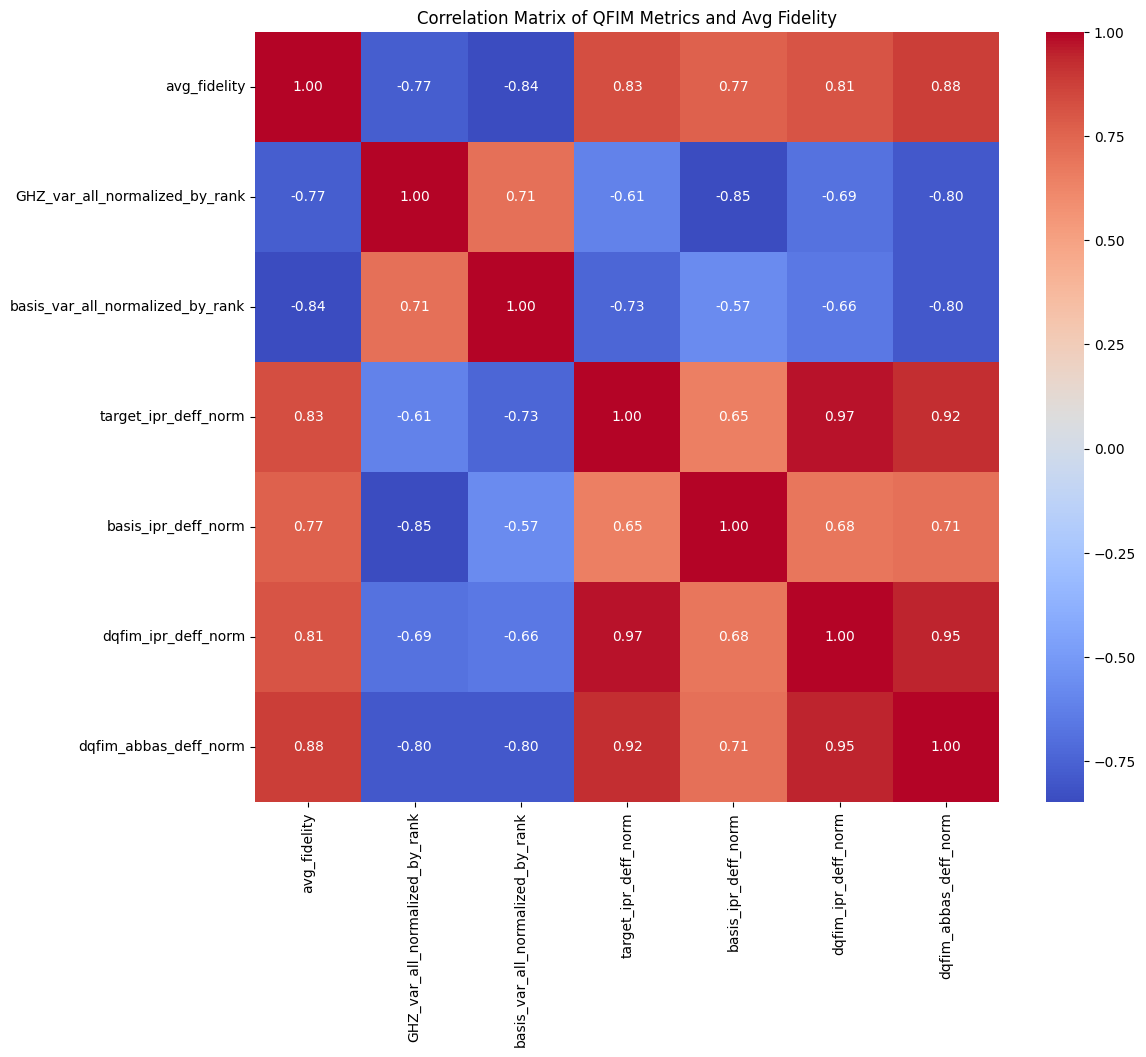

In [37]:
import seaborn as sns
predictors = ['avg_fidelity','GHZ_var_all_normalized_by_rank','basis_var_all_normalized_by_rank','target_ipr_deff_norm','basis_ipr_deff_norm','dqfim_ipr_deff_norm','dqfim_abbas_deff_norm']
corr_matrix = df_agg_by_test_key[predictors].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of QFIM Metrics and Avg Fidelity")
plt.show()

In [129]:
import plotly.express as px
predictor_metrics = [
 
    # 'error',
   'basis_var_all_normalized_by_rank','basis_ipr_deff_norm','dqfim_ipr_deff_norm','target_ipr_deff_norm'

]
metrics_to_visualize = [
    "test_key",
    'avg_fidelity',
    
]
metrics_to_visualize.extend(predictor_metrics)
df_viz = df_agg_by_test_key[metrics_to_visualize].dropna()

fig = px.scatter_matrix(
    df_viz,
    dimensions=predictor_metrics,
    color="avg_fidelity",        # Use fidelity as the color dimension
    hover_data=["test_key"],      # Show test_key on hover
    title="Scatter Matrix of Predictors with Fidelity as Color",
    # template="plotly_white"  # sets white background
)
fig.update_layout(width=1000, height=1000)
fig.show()



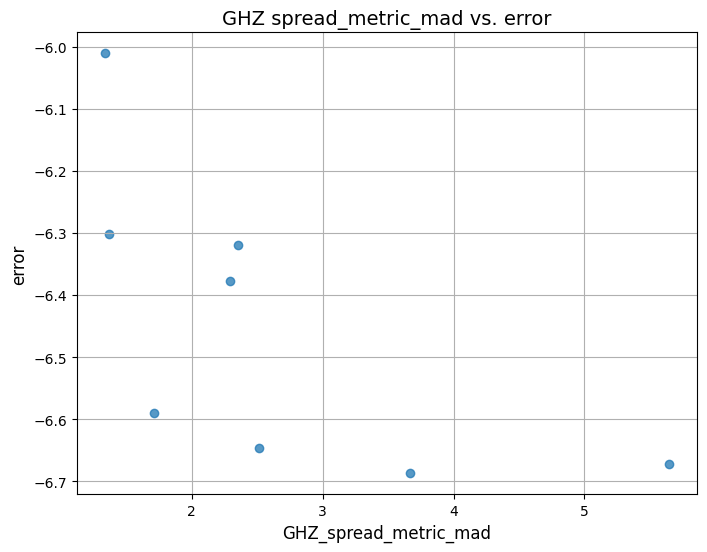

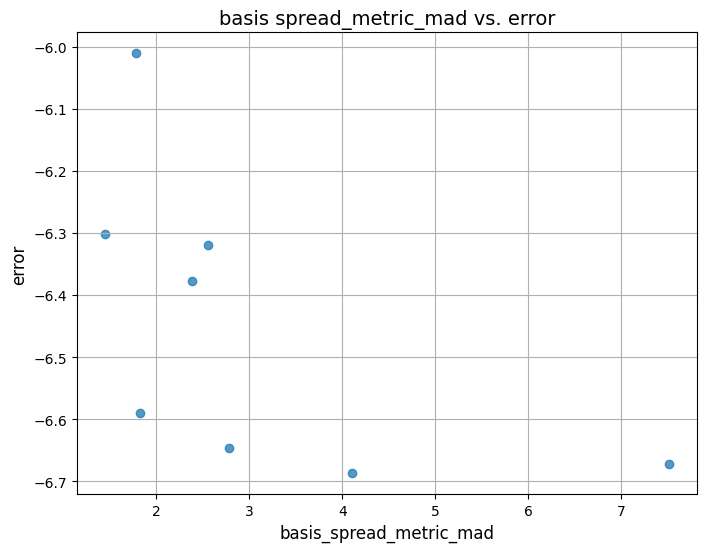

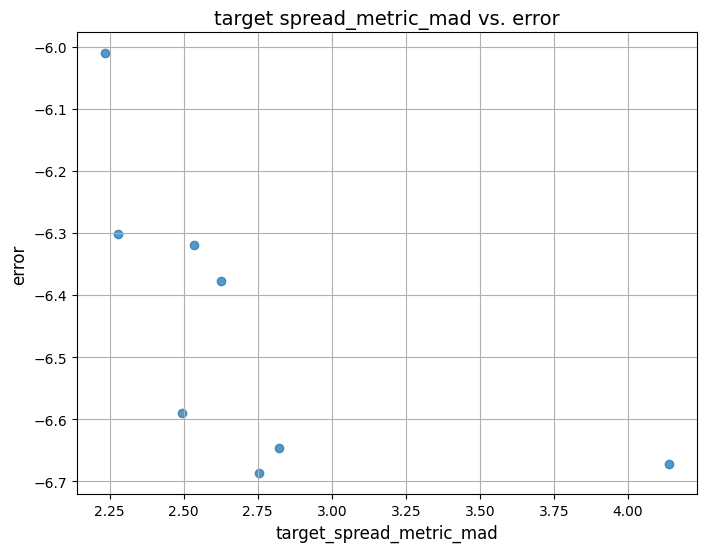

In [89]:
import matplotlib.pyplot as plt

def plot_metric_vs_error(df, qfim_type, x_metric, error_col="error", title=None):
    """
    Plots a scatter plot for a given quantum fisher representation.
    
    Parameters
    ----------
    df : pd.DataFrame
        Aggregated DataFrame (one row per test_key) that contains the computed QFIM metrics 
        and the error (e.g., computed as np.mean(np.log(1 - fidelity))).
    qfim_type : str
        The type of QFIM representation. Must be one of "GHZ", "basis", "dqfim", or "target".
    x_metric : str
        The metric (without prefix) to plot on the x-axis. For example, "abbas_deff_norm".
        The function will look for a column named f"{qfim_type}_{x_metric}".
    error_col : str, default "error"
        The column name to use for the error values on the y-axis.
    title : str, optional
        A title for the plot. If not provided, a default title will be generated.
    
    Returns
    -------
    None. Displays the plot.
    """
    
    # Construct the full column name for the metric.
    full_x_col = f"{qfim_type}_{x_metric}"
    if full_x_col not in df.columns:
        raise ValueError(f"Column {full_x_col} not found in the DataFrame.")
    
    # Extract the data.
    x_data = df[full_x_col]
    y_data = df[error_col]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(x_data, y_data, alpha=0.75)
    plt.xlabel(full_x_col, fontsize=12)
    plt.ylabel(error_col, fontsize=12)
    if title is None:
        title = f"{qfim_type} {x_metric} vs. {error_col}"
    plt.title(title, fontsize=14)
    plt.grid(True)
    plt.show()


# Example usage:
# Assume df_agg_by_test_key is your aggregated DataFrame (one row per test_key)'GHZ_spread_metric_mad','basis_spread_metric_mad','target_spread_metric_mad'
# and you want to plot, for example, "abbas_deff_norm" (without prefix) for the target DQFIM.
plot_metric_vs_error(df_agg_by_test_key, qfim_type="GHZ", x_metric="spread_metric_mad")
plot_metric_vs_error(df_agg_by_test_key, qfim_type="basis", x_metric="spread_metric_mad")
plot_metric_vs_error(df_agg_by_test_key, qfim_type="target", x_metric="spread_metric_mad")

In [157]:
def plot_metric_vs_error_plotly(
    df,
    qfim_type,
    x_metric,
    error_col="error",
    title=None,
    add_trendline=False,
    n_colors=100,
    width=800,
    height=600
):
    """
    Plot a scatter of one QFIM metric vs. error, with the points colored by the same error.
    This is useful to visualize how error changes with the metric, and the color scale 
    helps distinguish overlapping points.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns for the QFIM metrics and an error column.
    qfim_type : str
        The QFIM type (e.g. "GHZ", "basis", "dqfim", "target").
        If None, x_metric is assumed to be a direct column name in df.
    x_metric : str
        The base name of the metric for the x-axis (without prefix if qfim_type is None).
    error_col : str, default "error"
        The column name for the error values (y-axis and color).
    title : str, optional
        Plot title. If None, a default is generated.
    add_trendline : bool, optional
        If True, add an OLS trendline across all points.
    n_colors : int, optional
        Number of color steps in the custom colormap.
    width, height : int
        Plot width and height in pixels.

    Returns
    -------
    fig : plotly.graph_objects.Figure
        A scatter plot with a bounding box, black marker borders, 
        and a color bar for the error values.
    """
    import plotly.express as px
    import numpy as np
    import seaborn as sns
    import matplotlib.colors as mcolors
    from matplotlib.colors import LinearSegmentedColormap

    # 1) Construct x_col
    if qfim_type is not None:
        x_col = f"{qfim_type}_{x_metric}"
    else:
        x_col = x_metric

    # Check columns
    for col in [x_col, error_col]:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    # 2) Build a custom color scale from the error range
    data_min = df[error_col].min()
    data_max = df[error_col].max()
    if np.isclose(data_min, data_max):
        data_max = data_min + 1e-12

    values = np.linspace(data_min, data_max, n_colors) ** 4
    base_colormap = plt.cm.viridis
    # base_colormap = sns.color_palette("Spectral", as_cmap=True).reversed()
    # base_colormap = sns.color_palette("YlGn", as_cmap=True).reversed()
    colors_rgba = base_colormap((values - values.min()) / (values.max() - values.min()))
    # 'YlGn'
    custom_cmap = LinearSegmentedColormap.from_list('vibrant', colors_rgba, N=n_colors)
    plotly_color_scale = [mcolors.to_hex(custom_cmap(i)) for i in np.linspace(0, 1, n_colors)]

    # 3) Trend line options
    trendline_option = "ols" if add_trendline else None

    # 4) Create the scatter plot
    fig = px.scatter(
        df,
        x=x_col,
        y=error_col,
        color=error_col,
        color_continuous_scale=plotly_color_scale,
        title=title if title else f"{x_col} vs {error_col} colored by {error_col}",
        hover_data=["test_key"],
        template="plotly_white",
        trendline=trendline_option,
        trendline_scope="overall",
        trendline_color_override="red",
        width=width,
        height=height
    )

    # 5) Marker styling
    fig.update_traces(
        marker=dict(
            size=12,
            line=dict(width=1, color="black"),
            symbol="circle"
        )
    )

    # 6) Adjust color bar and bounding box
    fig.update_layout(
        coloraxis_colorbar=dict(
            title=error_col,
            len=0.9,
            thickness=30,
            y=0.5,
            yanchor="middle",
            x=1.03
        ),
        shapes=[
            dict(
                type="rect",
                xref="paper", yref="paper",
                x0=0, y0=0, x1=1, y1=1,
                line=dict(color="black", width=2),
                layer="below"
            )
        ]
    )

    return fig
fig =plot_metric_vs_error_plotly(df_agg_by_test_key, qfim_type="GHZ", x_metric="spread_metric_mad")
fig.show()

In [ ]:
import plotly.express as px
from matplotlib.colors import LinearSegmentedColormap
# Example of building a custom colormap
n_colors = 100

def plot_two_metrics_with_color(
    df,
    x_qfim_type,
    x_metric,
    y_qfim_type,
    y_metric,
    color_metric,
    title=None,
    add_trendline=True,
    n_colors=100,
    width=1000,
    height=600
):
    """
    Create a scatter plot comparing two metrics (x and y axes), potentially from 
    different QFIM types, with points colored by a third metric.
    
    If x_qfim_type or y_qfim_type is None, we assume that x_metric or y_metric
    is already a column in df (e.g. "error", "avg_fidelity").

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with one row per test_key (or per gate) containing QFIM metrics.
    x_qfim_type : str or None
        QFIM type for the x-axis metric (e.g. "GHZ", "basis", "dqfim", "target") 
        or None if x_metric is already a column in df with no prefix.
    x_metric : str
        The metric name for the x-axis (no prefix if x_qfim_type is None).
    y_qfim_type : str or None
        QFIM type for the y-axis metric, or None if y_metric is already a column in df.
    y_metric : str
        The metric name for the y-axis (no prefix if y_qfim_type is None).
    color_metric : str
        The column name (or QFIM metric name) used for coloring the points.
        (If you want to color by a QFIM metric with a prefix, pass the full col name.)
    title : str, optional
        Custom title for the plot. If None, a default is generated.
    add_trendline : bool, optional
        If True, add an Ordinary Least Squares (OLS) trendline across all points.
    n_colors : int, optional
        Number of steps in the custom colormap.
    width, height : int
        Plot width and height in pixels.

    Returns
    -------
    fig : plotly.graph_objects.Figure
        Scatter plot with custom color scale, bounding box, black marker borders, 
        and optional OLS trend line.
    """
    # 1) Construct the full column names for x and y
    if x_qfim_type is not None:
        x_col = f"{x_qfim_type}_{x_metric}"
    else:
        x_col = x_metric  # no prefix

    if y_qfim_type is not None:
        y_col = f"{y_qfim_type}_{y_metric}"
    else:
        y_col = y_metric  # no prefix

    color_col = color_metric  # e.g., "avg_fidelity", or "target_abbas_deff_norm", etc.

    # Check that the columns exist
    for col in [x_col, y_col, color_col]:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    # 2) Build a custom color scale based on the data range of color_col
    data_min = df[color_col].min()
    adj_min = data_min + 0.1 * abs(data_min)
    print(f"data_min: {data_min}")
    data_max = df[color_col].max()
    if np.isclose(data_min, data_max):
        data_max = data_min + 1e-12

    values = np.linspace(data_min, data_max, n_colors) ** 2
    base_colormap = sns.color_palette("Spectral", as_cmap=True).reversed()
    colors_rgba = base_colormap((values - values.min()) / (values.max() - values.min()))
    custom_cmap = LinearSegmentedColormap.from_list('vibrant', colors_rgba, N=n_colors)
    plotly_color_scale = [mcolors.to_hex(custom_cmap(i)) for i in np.linspace(0, 1, n_colors)]
    print(values)
    # 3) Trend line options
    trendline_option = "ols" if add_trendline else None
    # 4. Create the scatter plot
    #    trendline_scope="overall" forces a single line across the entire dataset.
    fig = px.scatter(
        df,
        x=x_col,
        y=y_col,
        color=color_col,
        color_continuous_scale=plotly_color_scale,
        range_color=[adj_min, data_max],
        title=title if title else f"{x_col} vs {y_col} colored by {color_col}",
        hover_data=["test_key"],
        template="plotly_white",
        trendline=trendline_option,
        trendline_scope="overall",
        trendline_color_override="red",
        width=width,
        height=height
    )


    # 5. Marker styling: bigger, black border
    fig.update_traces(
        marker=dict(
            size=12,
            line=dict(width=0.75, color="black"),
            symbol="circle"
        )
    )

    # 6. Adjust color bar: make it the full height of the plot
    fig.update_layout(
        coloraxis_colorbar=dict(
            title=color_col,
            len=1.1,            # 100% of plot height
            thickness=35,       # adjust width of the color bar
            yanchor="middle",   # center it vertically
            x=1.0,             # shift slightly to the right
            y=0.53
        ),
        shapes=[
            dict(
                type="rect",
                xref="paper", yref="paper",
                x0=0, y0=0, x1=1, y1=1,
                line=dict(color="black", width=2),
                layer="below"
            )
        ]
    )
    # fig.update_layout(
    #     coloraxis_colorbar=dict(
    #         title=color_col,
    #         len=1.1,
    #         thickness=35,
    #         y=0.53,            # center vertically
    #         # yanchor="middle",
    #         x=1.0           # shift to the right
    #     ),
    #     shapes=[
    #         dict(
    #             type="rect",
    #             xref="paper", yref="paper",
    #             x0=0, y0=0, x1=1, y1=1,
    #             line=dict(color="black", width=2),
    #             layer="below"
    #         )
    #     ]
    # )

    return fig



fig = plot_two_metrics_with_color(
    df_agg_by_test_key,
    x_qfim_type="target",
   
    x_metric="abbas_deff_norm",
    y_qfim_type="target",
    y_metric="d_eff",
    color_metric="avg_fidelity",
    add_trendline=False
)
fig.show() 



# 'basis_spread_metric_mad','basis_trace_normalized_by_rank','basis_var_all_normalized_by_rank'

data_min: 0.9955062766514824
[0.99103275 0.99108774 0.99114274 0.99119774 0.99125274 0.99130774
 0.99136274 0.99141774 0.99147275 0.99152776 0.99158276 0.99163777
 0.99169279 0.9917478  0.99180281 0.99185783 0.99191285 0.99196787
 0.99202289 0.99207791 0.99213293 0.99218796 0.99224299 0.99229802
 0.99235305 0.99240808 0.99246311 0.99251814 0.99257318 0.99262822
 0.99268326 0.9927383  0.99279334 0.99284838 0.99290343 0.99295848
 0.99301352 0.99306857 0.99312363 0.99317868 0.99323373 0.99328879
 0.99334385 0.99339891 0.99345397 0.99350903 0.99356409 0.99361916
 0.99367422 0.99372929 0.99378436 0.99383943 0.99389451 0.99394958
 0.99400466 0.99405973 0.99411481 0.99416989 0.99422497 0.99428006
 0.99433514 0.99439023 0.99444532 0.99450041 0.9945555  0.99461059
 0.99466568 0.99472078 0.99477588 0.99483098 0.99488608 0.99494118
 0.99499628 0.99505139 0.99510649 0.9951616  0.99521671 0.99527182
 0.99532693 0.99538205 0.99543716 0.99549228 0.9955474  0.99560252
 0.99565764 0.99571276 0.99576789

In [84]:

fig = plot_two_metrics_with_color(
    df_agg_by_test_key,
    qfim_type="basis",
    x_metric="trace_normalized_by_rank",
    y_metric="var_all_normalized_by_rank",
    color_metric="avg_fidelity",
    add_trendline=False
)
fig.show() 

In [ ]:

fig = plot_two_metrics_with_color(
    df_agg_by_test_key,
    qfim_type="basis",
    x_metric="trace_normalized_by_rank",
    y_metric="var_all_normalized_by_rank",
    color_metric="avg_fidelity",
    add_trendline=False
)
fig.show() 

In [11]:
def aggregate_by_test_key_only(df):
    print(df.keys())
    aggregated = df.groupby("test_key").agg(
       
        avg_fidelity=("avg_fidelity", "mean"),
        avg_infidelity=("avg_fidelity", lambda x: np.mean(1-x)),
        avg_error=("avg_fidelity", lambda x: np.mean(np.log(1 - x))),
        qfim_eigvals_GHZ=("qfim_eigvals", "first"),
        qfim_full=("qfim_full", "first"),
        entropy=("entropy", "first"),
        N_ctrl=("N_ctrl", "first"),
        N_reserv=("N_R", "first"),
        Trotter_Step=("Trotter_Step", "first")
    ).reset_index()
    cols_to_avg = [col for col in df.columns 
                   if col not in ['gate', 'fidelities_list', 'file_path', 'test_key']]
    
    # Group by test_key and compute the mean of all numeric columns.
    aggregated = df.groupby("test_key")[cols_to_avg].mean().reset_index()
    return aggregated

# For example, starting with your final DataFrame that has one row per test_key/gate:
df_by_gate = df_final  # your existing per-gate DataFrame
df_aggregated = aggregate_by_test_key_only(df_by_gate)
print("Aggregated DataFrame (one row per test_key):", df_aggregated.shape)



TypeError: agg function failed [how->mean,dtype->object]

In [17]:
import numpy as np
import pandas as pd
def aggregate_results_list(df):
    """
    Aggregate the DataFrame by test_key.
    For each test key:
      - fidelities_list: a list of fidelity values (one per gate).
      - avg_fidelity: the mean fidelity (using the pandas mean).
      - error: aggregated error computed as the mean of log(1 - fidelity).
      - qfim_eigvals: taken from the first row.
      - entropy: extracted from the first row's qfim_stats.
    
    Returns a new DataFrame with one row per test key.
    """
    print(df.keys())
    aggregated = df.groupby("test_key").agg(
        fidelities_list=("fidelity", list),
        avg_fidelity=("fidelity", "mean"),
        error=("fidelity", lambda x: np.mean(np.log(1 - x))),
        qfim_eigvals=("qfim_eigvals", "first"),
        qfim_full=("qfim_full", "first"),
        entropy=("entropy", "first"),
        N_ctrl=("N_ctrl", "first"),
        N_reserv=("N_R", "first"),
        Trotter_Step=("Trotter_Step", "first")
    ).reset_index()
    
    return aggregated

df_agg = aggregate_results_list(df_results)
print("Aggregated DataFrame shape:", df_agg.shape)
display(df_agg.keys())



# Update with computed QFIM metrics for each variant.
df_final = update_with_all_qfim_metrics(df_agg, threshold=1e-12, spread_methods=("variance", "mad"),
                                        ddof=1, scale="normal", gamma=0.1, n=1, V_theta=1.0)




Index(['costs', 'fidelity', 'num_params', 'test_results', 'qfim_eigvals',
       'qfim_full', 'entropy', 'N_ctrl', 'Trotter_Step', 'N_R', 'gate',
       'test_key', 'gate_folder', 'file_path'],
      dtype='object')
Aggregated DataFrame shape: (8, 10)


Index(['test_key', 'fidelities_list', 'avg_fidelity', 'error', 'qfim_eigvals',
       'qfim_full', 'entropy', 'N_ctrl', 'N_reserv', 'Trotter_Step'],
      dtype='object')

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_76635/2990458844.py:210: ComplexWarning:

Casting complex values to real discards the imaginary part



In [ ]:

# Then update with QFIM metrics as before:
def update_with_qfim_metrics(df, threshold=1e-12, spread_methods=("variance", "mad"),
                             ddof=1, scale="normal", 
                             gamma=0.1, n=1, V_theta=1.0):
    """
    For each row in df (representing one test key), call compute_single_draw_stats 
    with the provided parameters.
    """
    new_rows = []
    for _, row in df.iterrows():
        eigvals = row["qfim_eigvals"]
        full_qfim_mat = row['qfim_full']
        qfim_metrics = compute_single_draw_stats(
            eigvals,
            full_qfim_mat,
            threshold=threshold,
            spread_methods=spread_methods,
            ddof=ddof,
            scale=scale,
            gamma=gamma,
            n=n,
            V_theta=V_theta,
            n_ctrl=row["N_ctrl"],
            n_reserv=row["N_reserv"],
            trotter_step=row["Trotter_Step"]
        )
        updated_row = row.to_dict()
        updated_row.update(qfim_metrics)
        new_rows.append(updated_row)
    return pd.DataFrame(new_rows)

df_final = update_with_qfim_metrics(df_agg)



In [ ]:
import pingouin as pg

def analyze_correlations(df_merged, x_metric, metrics_of_interest, corr_threshold=0.2, p_threshold=0.05):
    """
    Analyze pairwise correlations between a given x_metric and each metric in metrics_of_interest.
    
    Parameters
    ----------
    df_merged : pd.DataFrame
        The merged DataFrame containing the columns of interest.
    x_metric : str
        The column name for the independent variable (e.g., "avg_fidelity").
    metrics_of_interest : list of str
        List of column names whose correlations with x_metric will be computed.
    corr_threshold : float, optional
        Minimum absolute correlation coefficient to report (default 0.2).
    p_threshold : float, optional
        Maximum p-value threshold to report (default 0.05).
        
    Returns
    -------
    pearson_results : dict
        Dictionary mapping each metric to its Pearson correlation coefficient and p-value.
    spearman_results : dict
        Dictionary mapping each metric to its Spearman correlation coefficient and p-value.
    """
    # Create a new DataFrame with the columns of interest and drop rows with NaN values.
    df_corr = df_merged[[x_metric] + metrics_of_interest].copy()
    df_corr = df_corr.dropna(subset=[x_metric] + metrics_of_interest)
    # print("Columns in df_corr:", df_corr.columns)
    # print("Number of rows after dropna:", len(df_corr))
    
    # Ensure that each metric column contains float values (e.g., convert from JAX arrays if needed)
    for col in metrics_of_interest:
        df_corr[col] = df_corr[col].apply(
            lambda val: float(val.item()) if hasattr(val, "item") else float(val)
        )
    
    # Compute Pearson correlations for each metric.
    pearson_results = {}
    for col in metrics_of_interest:
        res_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="pearson")
        r_val = res_df["r"].iloc[0]
        p_val = res_df["p-val"].iloc[0]
        pearson_results[col] = {"pearson_r": r_val, "p_value": p_val}
    
    # Compute Spearman correlations for each metric.
    spearman_results = {}
    for col in metrics_of_interest:
        sp_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="spearman")
        rho_val = sp_df["r"].iloc[0]
        p_val = sp_df["p-val"].iloc[0]
        spearman_results[col] = {"spearman_rho": rho_val, "p_value": p_val}
    
    # Print out the correlations that meet the filtering thresholds.
    print(f"\nPairwise correlations vs. {x_metric} (Pearson):")
    for metric, vals in pearson_results.items():
        if abs(vals["pearson_r"]) > corr_threshold and vals["p_value"] < p_threshold:
            print(f"{metric}: r={vals['pearson_r']:.3f}, p={vals['p_value']:.3g}")
    
    print(f"\nPairwise correlations vs. {x_metric} (Spearman):")
    for metric, vals in spearman_results.items():
        if abs(vals["spearman_rho"]) > corr_threshold and vals["p_value"] < p_threshold:
            print(f"{metric}: rho={vals['spearman_rho']:.3f}, p={vals['p_value']:.3g}")
    
    return pearson_results, spearman_results
x_metric = "error"
metrics_of_interest = [
    'trace_normalized_by_rank',                # Trace of QFIM
    'trace_normalized_by_rank_dqfim',
    'var_all_eigenvalues',
   'var_all_eigenvalues_dqfim',  
    'spread_metric_mad',
    'spread_metric_mad_dqfim', 
    'spread_metric_variance', 
    "spread_metric_variance_dqfim", 
    "d_eff", "d_eff_dqfim"
]
metrics_of_interest = [
    "entropy","var_all_eigenvalues", "var_nonzero_eigenvalues", "trace_eigenvalues",
    "var_nonzero_log", "var_nonzero_normalized_by_rank",
    "trace_normalized_by_rank",
    "ipr_deff_raw", "ipr_deff_norm",
    "spread_metric_variance", "spread_metric_mad",
    "trace_dqfim","trace_normalized_by_param_count_dqfim",
   "var_all_eigenvalues_dqfim","var_nonzero_log_dqfim",
    "var_nonzero_eigenvalues_dqfim", "var_all_normalized_by_param_count_dqfim",
    "var_nonzero_normalized_by_rank_dqfim", "ipr_deff_raw_dqfim",
    "ipr_deff_norm_dqfim", "abbas_deff_raw_dqfim", "abbas_deff_norm_dqfim",
    "spread_metric_variance_dqfim", "spread_metric_mad_dqfim",
    "d_eff", "d_eff_dqfim"
]
pearson_corrs, spearman_corrs = analyze_correlations(
    df_merged, x_metric, metrics_of_interest,
    corr_threshold=0.1, p_threshold=0.05
)

In [16]:
import math

def collect_dqfim_stats(all_tests_data, fixed_params_key, threshold=1e-12, gamma=0.1, n=100):
    """
    Build a single dictionary-of-dicts for the DQFIM stats keyed by test_key.

    Returns a dict:

        {
           test_key1: {
               "draw_rank": ...,
               "trace_eigenvalues": ...,
               "ipr_deff_raw_dqfim": ...,
               ... all metrics ...
           },
           test_key2: {...},
           ...
        }

    Then we can convert to a DataFrame and merge.
    """
    dqfim_stats_dict = {}
    test_data = all_tests_data[fixed_params_key]

    for test_key, results in test_data.items():
        qfi_eigvals = results["qfim_eigvals"]
        qfim_mat = results["qfim"]
        # call your single-draw function
        stats = compute_single_draw_stats(
            qfi_eigvals,
            qfim_mat,
            threshold=threshold,
            gamma=gamma,
            n=n,           # number of data-based states
        )
      
        # rename or store with distinct suffix (e.g. "_dqfim") if you want
        # so they don’t collide with existing columns
        dqfim_stats_dict[test_key] = {
            "draw_rank_dqfim": stats["draw_rank"],
            "trace_dqfim": stats["trace_eigenvalues"],
            "trace_normalized_by_rank_dqfim": stats["trace_normalized_by_rank"],
            "trace_normalized_by_param_count_dqfim": stats["trace_normalized_by_param_count"],
            "var_all_eigenvalues_dqfim": stats["var_all_eigenvalues"],
            "var_nonzero_eigenvalues_dqfim": stats["var_nonzero_eigenvalues"],
            "var_all_normalized_by_param_count_dqfim": stats["var_all_normalized_by_param_count"],
            "var_all_normalized_by_rank_dqfim": stats["var_all_normalized_by_rank"],
            "var_nonzero_normalized_by_rank_dqfim": stats["var_nonzero_normalized_by_rank"],
             "var_nonzero_log_dqfim": stats["var_nonzero_log"],
            "ipr_deff_raw_dqfim": stats["ipr_deff_raw"],
            "ipr_deff_norm_dqfim": stats["ipr_deff_norm"],
            "abbas_deff_raw_dqfim": stats["abbas_deff_raw"],
            "abbas_deff_norm_dqfim": stats["abbas_deff_norm"],
            # And the spread-of-log results:
            "spread_metric_variance_dqfim": stats.get("spread_metric_variance", 0.0),
            "spread_metric_mad_dqfim": stats.get("spread_metric_mad", 0.0),
            "d_eff_dqfim": stats.get("d_eff",0.0)
        }
    return dqfim_stats_dict


L = 100
T = 14
file_path = (
    f"/Users/sophieblock/QRCcapstone/parameter_analysis_directory/"
    f"QFIM_global_results/gate_model_DQFIM/Nc_2/sample_pi/1bbxK/"
    f"Nr_1/trotter_step_{T}/L_{L}/data.pickle"
)
print(file_path)
with open(file_path, 'rb') as f:
    all_tests_data = pickle.load(f)

fixed_params_key = "fixed_params0"
dqfim_stats_dict = collect_dqfim_stats(
    all_tests_data,
    fixed_params_key,
    threshold=1e-12,
    gamma=1.0,
    n=L
)


# Convert the dictionary-of-dicts to a DataFrame, keyed by test_key
df_dqfim = pd.DataFrame.from_dict(dqfim_stats_dict, orient="index")
df_dqfim.reset_index(inplace=True)
df_dqfim.rename(columns={"index": "test_key"}, inplace=True)

# Now df_dqfim has columns like:
#   test_key, trace_dqfim, var_all_eigenvalues_dqfim, ...
# Merge onto df_final on 'test_key'
df_merged = pd.merge(df_final, df_dqfim, on="test_key", how="left")

# print("df_merged columns:", df_merged.columns)

df_merged['test_key'].unique()


/Users/sophieblock/QRCcapstone/parameter_analysis_directory/QFIM_global_results/gate_model_DQFIM/Nc_2/sample_pi/1bbxK/Nr_1/trotter_step_14/L_100/data.pickle


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_76635/2990458844.py:210: ComplexWarning:

Casting complex values to real discards the imaginary part



array(['test104', 'test122', 'test129', 'test175', 'test18', 'test197',
       'test7', 'test79'], dtype=object)

In [11]:
import pingouin as pg

def analyze_correlations(df_merged, x_metric, metrics_of_interest, corr_threshold=0.2, p_threshold=0.05):
    """
    Analyze pairwise correlations between a given x_metric and each metric in metrics_of_interest.
    
    Parameters
    ----------
    df_merged : pd.DataFrame
        The merged DataFrame containing the columns of interest.
    x_metric : str
        The column name for the independent variable (e.g., "avg_fidelity").
    metrics_of_interest : list of str
        List of column names whose correlations with x_metric will be computed.
    corr_threshold : float, optional
        Minimum absolute correlation coefficient to report (default 0.2).
    p_threshold : float, optional
        Maximum p-value threshold to report (default 0.05).
        
    Returns
    -------
    pearson_results : dict
        Dictionary mapping each metric to its Pearson correlation coefficient and p-value.
    spearman_results : dict
        Dictionary mapping each metric to its Spearman correlation coefficient and p-value.
    """
    # Create a new DataFrame with the columns of interest and drop rows with NaN values.
    df_corr = df_merged[[x_metric] + metrics_of_interest].copy()
    df_corr = df_corr.dropna(subset=[x_metric] + metrics_of_interest)
    # print("Columns in df_corr:", df_corr.columns)
    # print("Number of rows after dropna:", len(df_corr))
    
    # Ensure that each metric column contains float values (e.g., convert from JAX arrays if needed)
    for col in metrics_of_interest:
        df_corr[col] = df_corr[col].apply(
            lambda val: float(val.item()) if hasattr(val, "item") else float(val)
        )
    
    # Compute Pearson correlations for each metric.
    pearson_results = {}
    for col in metrics_of_interest:
        res_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="pearson")
        r_val = res_df["r"].iloc[0]
        p_val = res_df["p-val"].iloc[0]
        pearson_results[col] = {"pearson_r": r_val, "p_value": p_val}
    
    # Compute Spearman correlations for each metric.
    spearman_results = {}
    for col in metrics_of_interest:
        sp_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="spearman")
        rho_val = sp_df["r"].iloc[0]
        p_val = sp_df["p-val"].iloc[0]
        spearman_results[col] = {"spearman_rho": rho_val, "p_value": p_val}
    
    # Print out the correlations that meet the filtering thresholds.
    print(f"\nPairwise correlations vs. {x_metric} (Pearson):")
    for metric, vals in pearson_results.items():
        if abs(vals["pearson_r"]) > corr_threshold and vals["p_value"] < p_threshold:
            print(f"{metric}: r={vals['pearson_r']:.3f}, p={vals['p_value']:.3g}")
    
    print(f"\nPairwise correlations vs. {x_metric} (Spearman):")
    for metric, vals in spearman_results.items():
        if abs(vals["spearman_rho"]) > corr_threshold and vals["p_value"] < p_threshold:
            print(f"{metric}: rho={vals['spearman_rho']:.3f}, p={vals['p_value']:.3g}")
    
    return pearson_results, spearman_results
x_metric = "error"
metrics_of_interest = [
    'trace_normalized_by_rank',                # Trace of QFIM
    'trace_normalized_by_rank_dqfim',
    'var_all_eigenvalues',
   'var_all_eigenvalues_dqfim',  
    'spread_metric_mad',
    'spread_metric_mad_dqfim', 
    'spread_metric_variance', 
    "spread_metric_variance_dqfim", 
    "d_eff", "d_eff_dqfim"
]
metrics_of_interest = [
    "entropy","var_all_eigenvalues", "var_nonzero_eigenvalues", "trace_eigenvalues",
    "var_nonzero_log", "var_nonzero_normalized_by_rank",
    "trace_normalized_by_rank",
    "ipr_deff_raw", "ipr_deff_norm",
    "spread_metric_variance", "spread_metric_mad",
    "trace_dqfim","trace_normalized_by_param_count_dqfim",
   "var_all_eigenvalues_dqfim","var_nonzero_log_dqfim",
    "var_nonzero_eigenvalues_dqfim", "var_all_normalized_by_param_count_dqfim",
    "var_nonzero_normalized_by_rank_dqfim", "ipr_deff_raw_dqfim",
    "ipr_deff_norm_dqfim", "abbas_deff_raw_dqfim", "abbas_deff_norm_dqfim",
    "spread_metric_variance_dqfim", "spread_metric_mad_dqfim",
    "d_eff", "d_eff_dqfim"
]
pearson_corrs, spearman_corrs = analyze_correlations(
    df_merged, x_metric, metrics_of_interest,
    corr_threshold=0.1, p_threshold=0.05
)


Pairwise correlations vs. error (Pearson):

Pairwise correlations vs. error (Spearman):


In [12]:
print(f"\nPairwise correlations vs. {x_metric} (Pearson):")
for metric, vals in pearson_corrs.items():
    # if abs(vals["pearson_r"]) > corr_threshold and vals["p_value"] < p_threshold:
    print(f"{metric}: r={vals['pearson_r']:.3f}, p={vals['p_value']:.3g}")



Pairwise correlations vs. error (Pearson):
entropy: r=0.328, p=0.428
var_all_eigenvalues: r=0.487, p=0.221
var_nonzero_eigenvalues: r=0.490, p=0.217
trace_eigenvalues: r=0.331, p=0.423
var_nonzero_log: r=0.237, p=0.572
var_nonzero_normalized_by_rank: r=0.490, p=0.217
trace_normalized_by_rank: r=0.331, p=0.423
ipr_deff_raw: r=-0.177, p=0.675
ipr_deff_norm: r=-0.177, p=0.675
spread_metric_variance: r=-0.186, p=0.659
spread_metric_mad: r=-0.296, p=0.476
trace_dqfim: r=0.108, p=0.8
trace_normalized_by_param_count_dqfim: r=0.108, p=0.8
var_all_eigenvalues_dqfim: r=0.176, p=0.676
var_nonzero_log_dqfim: r=0.333, p=0.42
var_nonzero_eigenvalues_dqfim: r=0.185, p=0.661
var_all_normalized_by_param_count_dqfim: r=0.176, p=0.676
var_nonzero_normalized_by_rank_dqfim: r=0.185, p=0.661
ipr_deff_raw_dqfim: r=-0.578, p=0.133
ipr_deff_norm_dqfim: r=-0.578, p=0.133
abbas_deff_raw_dqfim: r=-0.087, p=0.838
abbas_deff_norm_dqfim: r=-0.510, p=0.197
spread_metric_variance_dqfim: r=-0.243, p=0.562
spread_metri

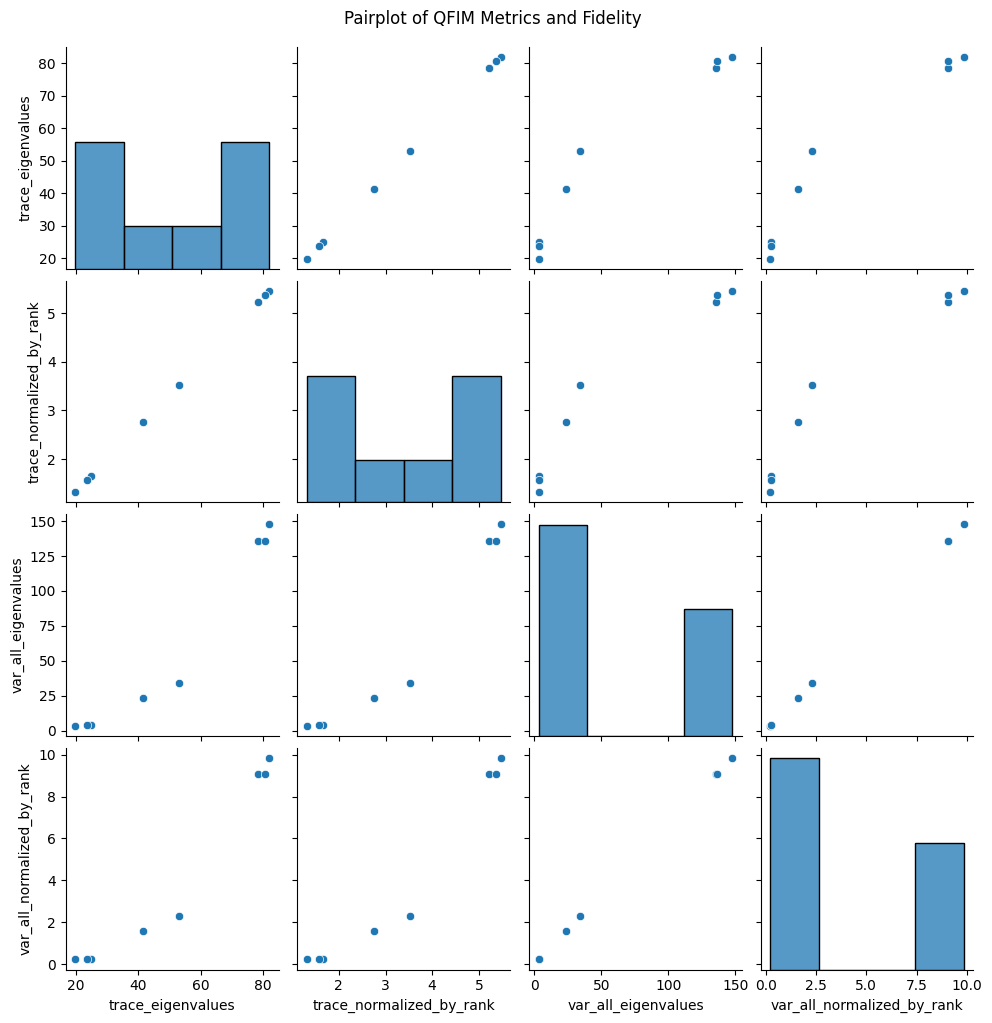

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Define the list of columns (metrics) you wish to examine.
# Adjust these names if your columns have different names.
metrics_to_plot = [
    # 'avg_fidelity',         # Averaged fidelity from test results
    "trace_eigenvalues",
    'trace_normalized_by_rank',                # Trace of QFIM
    # 'trace_normalized_by_rank_dqfim',
    'var_all_eigenvalues',
#    'var_all_eigenvalues_dqfim',  
   'var_all_normalized_by_rank',
#    'var_all_normalized_by_rank_dqfim'
    # 'spread_metric_mad',
    # 'spread_metric_mad_dqfim', 
    # 'spread_metric_variance',
    # 'spread_metric_variance_dqfim',      
     
   

    # 'ipr_deff_raw_dqfim',  # Effective dimension computed via the paper's formula
   
]


# # 2. Pair Plot
sns.pairplot(df_merged[metrics_to_plot])
plt.suptitle("Pairplot of QFIM Metrics and Fidelity", y=1.02)
plt.show()

In [14]:
import plotly.express as px
predictor_metrics = [
 
    'error',
    'trace_normalized_by_rank',                # Trace of QFIM
    # 'trace_normalized_by_rank_dqfim',
    'var_all_normalized_by_rank',
#    'var_all_eigenvalues_dqfim',  
    # 'spread_metric_mad',
    # 'spread_metric_mad_dqfim', 
    # 'spread_metric_variance', 
    # "spread_metric_variance_dqfim", 
    # "d_eff", "d_eff_dqfim"

]
metrics_to_visualize = [
    "test_key",
    'avg_fidelity',
    
]
metrics_to_visualize.extend(predictor_metrics)
df_viz = df_merged[metrics_to_visualize].dropna()

fig = px.scatter_matrix(
    df_viz,
    dimensions=predictor_metrics,
    color="avg_fidelity",        # Use fidelity as the color dimension
    hover_data=["test_key"],      # Show test_key on hover
    title="Scatter Matrix of Predictors with Fidelity as Color"
)
fig.update_layout(width=1000, height=1000)
fig.show()

In [31]:
predictor_metrics = [
 
    'error',
    'trace_normalized_by_rank_dqfim', 
    'var_all_normalized_by_rank_dqfim',
#    'var_all_eigenvalues_dqfim',  
    # 'spread_metric_mad',
    # 'spread_metric_mad_dqfim', 
    # 'spread_metric_variance', 
    # "spread_metric_variance_dqfim", 
    # "d_eff", "d_eff_dqfim"

]
metrics_to_visualize = [
    "test_key",
    'avg_fidelity',
    
]
metrics_to_visualize.extend(predictor_metrics)
df_viz = df_merged[metrics_to_visualize].dropna()

fig = px.scatter_matrix(
    df_viz,
    dimensions=predictor_metrics,
    color="avg_fidelity",        # Use fidelity as the color dimension
    hover_data=["test_key"],      # Show test_key on hover
    title="Scatter Matrix of Predictors with Fidelity as Color"
)
fig.update_layout(width=1000, height=1000)
fig.show()

In [ ]:
import plotly.express as px
predictor_metrics = [
    
    # 'trace_normalized_by_rank',
    # 'error',
    'var_nonzero_eigenvalues_dqfim',
    
    # 'trace_normalized_by_rank',
    # 'spread_metric_variance',
    # 'spread_metric_mad',
    # 'spread_metric_variance_dqfim',
    # "spread_metric_variance_dqfim"
    # "trace_normalized_by_rank"
    'abbas_deff_norm_dqfim',
    "abbas_deff_raw_dqfim",
    # "ipr_deff_raw_dqfim"
]
metrics_to_visualize = [
    "test_key",
    'avg_fidelity',
    'error',
    'trace_eigenvalues',
    'trace_normalized_by_rank',
    'var_nonzero_eigenvalues_dqfim',
    'var_nonzero_normalized_by_rank',
    'var_nonzero_log',
    'var_nonzero_normalized_by_rank_dqfim',
    'spread_metric_mad',
    'spread_metric_variance',
    'spread_metric_variance_dqfim',
    "spread_metric_mad_dqfim",
    "abbas_deff_raw_dqfim",
    "abbas_deff_norm_dqfim",
    "ipr_deff_raw_dqfim"
]

df_viz = df_merged[metrics_to_visualize].dropna()

fig = px.scatter_matrix(
    df_viz,
    dimensions=predictor_metrics,
    color="avg_fidelity",        # Use fidelity as the color dimension
    hover_data=["test_key"],      # Show test_key on hover
    title="Scatter Matrix of Predictors with Fidelity as Color"
)
fig.update_layout(width=1000, height=1000)
fig.show()

In [12]:
import plotly.express as px
predictor_metrics = [
    
    # 'trace_normalized_by_rank',
    'error',
    'var_nonzero_normalized_by_rank',
    
    'trace_normalized_by_rank',
    # 'spread_metric_variance',
    # 'spread_metric_mad',
    # 'spread_metric_variance_dqfim',
    # "spread_metric_variance_dqfim"
    # "trace_normalized_by_rank"
    # 'spread_metric_variance_dqfim',
    # "abbas_deff_raw_dqfim",
    # "ipr_deff_raw_dqfim"
]
metrics_to_visualize = [
    "test_key",
    'avg_fidelity',
    'error',
    'trace_eigenvalues',
    'trace_normalized_by_rank',
    'var_nonzero_normalized_by_rank',
    'var_nonzero_log',
    'var_nonzero_normalized_by_rank_dqfim',
    'spread_metric_mad',
    'spread_metric_variance',
    'spread_metric_variance_dqfim',
    "spread_metric_mad_dqfim",
    "abbas_deff_raw_dqfim",
    "abbas_deff_norm_dqfim",
    "ipr_deff_raw_dqfim"
]

df_viz = df_merged[metrics_to_visualize].dropna()

fig = px.scatter_matrix(
    df_viz,
    dimensions=predictor_metrics,
    color="avg_fidelity",        # Use fidelity as the color dimension
    hover_data=["test_key"],      # Show test_key on hover
    title="Scatter Matrix of Predictors with Fidelity as Color"
)
fig.update_layout(width=1000, height=1000)
fig.show()